## Init TF

In [1]:
import numpy as np
import tensorflow as tf

#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

from utils import *
import tensorflow_probability as tfp
import time
import os

#comment out for laptop use
from ipyvtklink.viewer import ViewInteractiveWidget

import pykitti
# from numba import cuda #gpu library used to clear gpu memory after each trial

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

Autosaving every 180 seconds


## ICET3D

In [203]:
from ICET3D import ICET3D

settings.embedWindow(backend='ipyvtk', verbose = True)

plt = Plotter(N=1, axes=1, bg = (0.1,0.1,0.1), bg2 = (0.3,0.3,0.3),  interactive=True)

# basedir = 'C:/kitti/'
# date = '2011_09_26'
# drive = '0005'
# frame_range = range(150, 151, 1)
# dataset = pykitti.raw(basedir, date, drive)
# velo1 = dataset.get_velo(0) # Each scan is a Nx4 array of [x,y,z,reflectance]
# cloud1 = velo1[:,:3]
# cloud1_tensor = tf.convert_to_tensor(cloud1, np.float32)
# velo2 = dataset.get_velo(2) # Each scan is a Nx4 array of [x,y,z,reflectance]
# cloud2 = velo2[:,:3]
# cloud2_tensor = tf.convert_to_tensor(cloud2, np.float32)
cloud1_tensor = None
cloud2_tensor = None

nc = 15
mnp = 50
npts = 100000
D = False #draw sim
DG = False #draw grid
DE = True #draw ellipsoids
DC = True #draw correspondences
TD = True #use test dataset
CM = "voxel" #correspondence method, "voxel" or "NN"

start = time.time()
# #use whole point set
# #---------------------------------------------------------------------------------
# f = tf.constant([50,50,2]) #fidelity in x, y, z # < 5s
# lim = tf.constant([-100.,100.,-100.,100.,-10.,10.]) #needs to encompass every point
# Q, x_hist = ICET3D(cloud1_tensor[:npts], cloud2_tensor[:npts], plt, bounds = lim, 
#            fid = f, num_cycles = nc , min_num_pts = mnp, draw = D, draw_grid = DG, 
#            draw_ell = DE, draw_corr = DC)
# #---------------------------------------------------------------------------------

#just consider small section of image where there are easily identifiable features:
#----------------------------------------------------------------------------------
limtest = tf.constant([-20.,0.,-20.,0.,-1.5,1.5])
# f = tf.constant([35,35,35])
# f = tf.constant([17,17,17])
f = tf.constant([21,21,21])
# cloud1_tensor = tf.squeeze(tf.gather(cloud1_tensor, tf.where( (cloud1_tensor[:,0] > limtest[0]))))	#only works one cond at a time

Q, x_hist, actual = ICET3D(cloud1_tensor, cloud2_tensor, plt, bounds = limtest, 
           fid = f, num_cycles = nc , min_num_pts = mnp, draw = D, draw_grid = DG,
           draw_ell = DE, draw_corr = DC, test_dataset = TD, CM = CM)
#----------------------------------------------------------------------------------
#NOTE: Out of Memory Error comes from too high fidelity/ pts in cloud tensor --> 100x100x2x120,000 > 2gb

print("took", time.time() - start, "seconds total")

# print(tf.sqrt(tf.math.abs(Q)))
ans = np.sqrt(abs(Q.numpy()))
print("\n predicted solution standard deviation of error: \n",ans[0,0], ans[1,1], ans[2,2], ans[3,3], ans[4,4], ans[5,5])
# print("\n Q \n", Q)
# ViewInteractiveWidget(plt.window)

tf.Tensor([55060     3], shape=(2,), dtype=int32)
took 0.1726524829864502 seconds with tensorflow
0 -----------------
took 0.1430339813232422 seconds with tensorflow

 x 
 tf.Tensor([-0.33326584 -1.2460346  -2.0597603   0.11572856  0.09316528  0.16804653], shape=(6,), dtype=float32)
1 -----------------
took 0.11252713203430176 seconds with tensorflow

 x 
 tf.Tensor([-0.50262123 -2.7798727  -2.1480844   0.11856358  0.10054619  0.19996937], shape=(6,), dtype=float32)
2 -----------------
took 0.1090242862701416 seconds with tensorflow

 x 
 tf.Tensor([-0.91358113 -3.100802   -1.9768213   0.12013368  0.10032241  0.19986476], shape=(6,), dtype=float32)
3 -----------------
took 0.11003375053405762 seconds with tensorflow

 x 
 tf.Tensor([-1.0184858  -3.0204005  -1.976743    0.1200715   0.10000401  0.20003214], shape=(6,), dtype=float32)
4 -----------------
took 0.11117911338806152 seconds with tensorflow

 x 
 tf.Tensor([-1.00451    -2.9971738  -1.9968154   0.12001266  0.10001053  0.2000267

In [95]:
#error
# x_hist[-1] + tf.constant([1., 3., 2., -0.12, -0.1, -0.2]) #T intersection
# x_hist[-1] + tf.constant([0., 1., 0., 0., 0., -0.1])      # simple wall
print(x_hist[-1] + actual)

# randy = tf.constant([tf.random.normal([1]).numpy(), tf.random.normal([1]).numpy(), 
#                   tf.random.normal([1]).numpy(), 0.03*tf.random.normal([1]).numpy(), 
#                   0.03*tf.random.normal([1]).numpy(), 0.1*tf.random.normal([1]).numpy()])
# randy = tf.squeeze(randy)
# print(randy)

tf.Tensor(
[ 1.19007826e-01  1.52487397e+00  1.09991729e-02 -1.73626468e-05
  3.81628051e-05  1.67414546e-05], shape=(6,), dtype=float32)


In [ ]:
#display progression of solution values
from matplotlib import pyplot as plt
fig1 = plt.figure()
ax1 = fig1.add_subplot()
ax1.set_xlabel("iteration")
ax1.set_ylabel("estimated rotation (rad)")

# ax1.plot(x_hist.numpy())
# ax1.legend(['x','y','z','phi','theta','psi'])
ax1.plot(x_hist[:,3:].numpy())
ax1.legend(['phi','theta','psi'])

# ax1.plot(np.linspace(1,15,15), 0.02*np.ones(15), 'g--')
# ax1.plot(np.linspace(1,15,15), 0.03*np.ones(15), 'r--')
# ax1.plot(np.linspace(1,15,15), 0.01*np.ones(15), 'b--')

In [ ]:
fig2 = plt.figure()
ax2 = fig2.add_subplot()
ax2.set_xlabel("iteration")
ax2.set_ylabel("estimated translation (cm)")

# ax1.plot(x_hist.numpy())
# ax1.legend(['x','y','z','phi','theta','psi'])
ax2.plot(x_hist[:,:3].numpy())
ax2.legend(['x','y','z'])

# ax2.plot(np.linspace(1,15,15), -.1*np.ones(15), 'g--')
# ax2.plot(np.linspace(1,15,15), -3*np.ones(15), 'r--')
# ax2.plot(np.linspace(1,15,15), -.2*np.ones(15), 'b--')

## ICET Monte-Carlo Simulation

In [105]:
plt = Plotter(N=1, axes=1, bg = (0.1,0.1,0.1), bg2 = (0.3,0.3,0.3),  interactive=True)

cloud1_tensor = None
cloud2_tensor = None
nc = 5
mnp = 50
npts = 100000
D = False #draw sim
DG = False #draw grid
DE = True #draw ellipsoids
DC = True #draw correspondences
TD = True #use test dataset
CM = "voxel" #correspondence method, "voxel" or "NN"
epochs = 100

# total_error = tf.zeros([1,6])
Q_total = tf.zeros([6,6])
errors = tf.zeros([1,6])

limtest = tf.constant([-20.,0.,-20.,0.,-1.5,1.5])
# f = tf.constant([35,35,35])
# f = tf.constant([17,17,17])
f = tf.constant([21,21,21])

for i in range(epochs):
    print("\n ~~~~~~~~~ Epoch ", i, " ~~~~~~~~~~~~~ \n")
    Q, x_hist, actual = ICET3D(cloud1_tensor, cloud2_tensor, plt, bounds = limtest, 
               fid = f, num_cycles = nc , min_num_pts = mnp, draw = D, draw_grid = DG,
               draw_ell = DE, draw_corr = DC, test_dataset = TD, CM = CM)

#     error_i = x_hist[-1] + tf.constant([1., 3., 2., -0.12, -0.1, -0.2]) #3D
    error_i = x_hist[-1] + tf.constant([1., 4., 2., -0., 0.0, -0.1]) # 2D
#     error_i = x_hist[-1] +  tf.constant([0., 1., 0., 0., 0., 0.1]) #1D
#     error_i = x_hist[-1] + actual
    
    # print("\n error_i \n", error_i)
    Q_total += Q
#     total_error += error_i
    errors = tf.concat((errors, error_i[None,:]), axis = 0)
errors = errors[1:] #get rid of placeholder value
    
# avg_error = total_error/epochs
# print("\n average solution errors \n", avg_error)
print("\n actual error std: \n", tf.math.reduce_std(errors, axis = 0))

ans = np.sqrt(abs((Q_total/epochs).numpy()))
print("\n predicted solution standard deviation of error: \n", ans[0,0], ans[1,1], ans[2,2], ans[3,3], ans[4,4], ans[5,5])


 ~~~~~~~~~ Epoch  0  ~~~~~~~~~~~~~ 

starting transformation 
 tf.Tensor([ 1.   4.   2.  -0.   0.  -0.1], shape=(6,), dtype=float32)
tf.Tensor([42300     3], shape=(2,), dtype=int32)
took 0.09902811050415039 seconds with tensorflow
0 -----------------
took 0.10302305221557617 seconds with tensorflow

 x 
 tf.Tensor(
[-9.6362323e-01 -1.4257801e-03 -1.9870839e+00  3.8462385e-05
 -1.0027224e-03  9.8414026e-02], shape=(6,), dtype=float32)
1 -----------------
took 0.09787631034851074 seconds with tensorflow

 x 
 tf.Tensor(
[-1.0056967e+00 -1.4548933e-03 -1.9981515e+00 -8.0632781e-05
 -1.6916939e-04  9.9965625e-02], shape=(6,), dtype=float32)
2 -----------------
took 0.09302043914794922 seconds with tensorflow

 x 
 tf.Tensor(
[-1.0064116e+00 -1.4553954e-03 -1.9983715e+00 -1.4293182e-06
 -1.2630709e-04  9.9962339e-02], shape=(6,), dtype=float32)
3 -----------------
took 0.09602069854736328 seconds with tensorflow

 x 
 tf.Tensor(
[-1.0065336e+00 -1.4554627e-03 -1.9983716e+00  3.7823620e-06


 x 
 tf.Tensor(
[-1.0081570e+00 -9.8097022e-04 -1.9970722e+00  2.7603053e-05
 -1.6761327e-05  9.9994391e-02], shape=(6,), dtype=float32)
3 -----------------
took 0.10152792930603027 seconds with tensorflow

 x 
 tf.Tensor(
[-1.0081372e+00 -9.8092924e-04 -1.9970925e+00  2.9420402e-05
 -2.1675565e-05  9.9994540e-02], shape=(6,), dtype=float32)
4 -----------------
took 0.10002303123474121 seconds with tensorflow

 x 
 tf.Tensor(
[-1.0081415e+00 -9.8093692e-04 -1.9970925e+00  2.8939650e-05
 -2.1970138e-05  9.9994533e-02], shape=(6,), dtype=float32)

 ~~~~~~~~~ Epoch  7  ~~~~~~~~~~~~~ 

starting transformation 
 tf.Tensor([ 1.   4.   2.  -0.   0.  -0.1], shape=(6,), dtype=float32)
tf.Tensor([42300     3], shape=(2,), dtype=int32)
took 0.1000220775604248 seconds with tensorflow
0 -----------------
took 0.10552453994750977 seconds with tensorflow

 x 
 tf.Tensor(
[-9.7278786e-01 -4.4158724e-04 -1.9928657e+00  5.6817502e-05
 -4.9560517e-04  9.8412909e-02], shape=(6,), dtype=float32)
1 -------

tf.Tensor([42300     3], shape=(2,), dtype=int32)
took 0.10202336311340332 seconds with tensorflow
0 -----------------
took 0.10202264785766602 seconds with tensorflow

 x 
 tf.Tensor(
[-9.60518539e-01  1.69342663e-03 -1.98788595e+00  1.15588206e-04
 -1.05757732e-03  9.83549058e-02], shape=(6,), dtype=float32)
1 -----------------
took 0.1020364761352539 seconds with tensorflow

 x 
 tf.Tensor(
[-1.0024586e+00  1.7183259e-03 -1.9971081e+00  3.1957316e-06
 -1.4521758e-04  9.9989235e-02], shape=(6,), dtype=float32)
2 -----------------
took 0.10002326965332031 seconds with tensorflow

 x 
 tf.Tensor(
[-1.0033101e+00  1.7187907e-03 -1.9972204e+00  8.8628731e-05
 -9.5411830e-05  9.9987119e-02], shape=(6,), dtype=float32)
3 -----------------
took 0.10808730125427246 seconds with tensorflow

 x 
 tf.Tensor(
[-1.0034263e+00  1.7188429e-03 -1.9972124e+00  9.4319948e-05
 -1.0761450e-04  9.9987112e-02], shape=(6,), dtype=float32)
4 -----------------
took 0.09902262687683105 seconds with tensorflow


 x 
 tf.Tensor(
[-9.9741340e-01 -1.4863962e-03 -2.0015976e+00 -4.1266241e-05
 -2.0315188e-04  9.9927284e-02], shape=(6,), dtype=float32)
3 -----------------
took 0.10002255439758301 seconds with tensorflow

 x 
 tf.Tensor(
[-9.9753892e-01 -1.4865608e-03 -2.0016017e+00 -3.7875390e-05
 -2.1330701e-04  9.9927872e-02], shape=(6,), dtype=float32)
4 -----------------
took 0.10252904891967773 seconds with tensorflow

 x 
 tf.Tensor(
[-9.9754548e-01 -1.4865694e-03 -2.0016017e+00 -3.8869446e-05
 -2.1385924e-04  9.9927865e-02], shape=(6,), dtype=float32)

 ~~~~~~~~~ Epoch  20  ~~~~~~~~~~~~~ 

starting transformation 
 tf.Tensor([ 1.   4.   2.  -0.   0.  -0.1], shape=(6,), dtype=float32)
tf.Tensor([42300     3], shape=(2,), dtype=int32)
took 0.10202550888061523 seconds with tensorflow
0 -----------------
took 0.10252761840820312 seconds with tensorflow

 x 
 tf.Tensor(
[-9.6572882e-01  1.0335320e-03 -1.9888126e+00 -1.2539991e-04
 -6.4101210e-04  9.8284513e-02], shape=(6,), dtype=float32)
1 -----

tf.Tensor([42300     3], shape=(2,), dtype=int32)
took 0.1000218391418457 seconds with tensorflow
0 -----------------
took 0.10352730751037598 seconds with tensorflow

 x 
 tf.Tensor(
[-9.7402084e-01 -5.7121745e-04 -1.9845532e+00 -6.6265566e-05
 -4.9227476e-04  9.8383226e-02], shape=(6,), dtype=float32)
1 -----------------
took 0.10052490234375 seconds with tensorflow

 x 
 tf.Tensor(
[-1.00064182e+00 -5.93813194e-04 -1.99992967e+00 -8.56809129e-05
 -1.04719657e-04  1.00030474e-01], shape=(6,), dtype=float32)
2 -----------------
took 0.10002255439758301 seconds with tensorflow

 x 
 tf.Tensor(
[-1.00072527e+00 -5.93890261e-04 -2.00007725e+00 -4.86335193e-05
 -1.07249805e-04  1.00028194e-01], shape=(6,), dtype=float32)
3 -----------------
took 0.09502172470092773 seconds with tensorflow

 x 
 tf.Tensor(
[-1.00074840e+00 -5.93909761e-04 -2.00008869e+00 -4.84140437e-05
 -1.13622358e-04  1.00028336e-01], shape=(6,), dtype=float32)
4 -----------------
took 0.09952712059020996 seconds with t


 x 
 tf.Tensor(
[-9.9534851e-01  1.0578253e-03 -2.0007112e+00 -2.8289913e-05
 -2.3386430e-04  9.9975698e-02], shape=(6,), dtype=float32)
3 -----------------
took 0.10302329063415527 seconds with tensorflow

 x 
 tf.Tensor(
[-9.9551213e-01  1.0578729e-03 -2.0007002e+00 -2.7005219e-05
 -2.3703485e-04  9.9975958e-02], shape=(6,), dtype=float32)
4 -----------------
took 0.10102224349975586 seconds with tensorflow

 x 
 tf.Tensor(
[-9.9551284e-01  1.0578731e-03 -2.0007000e+00 -2.7313446e-05
 -2.3724085e-04  9.9975951e-02], shape=(6,), dtype=float32)

 ~~~~~~~~~ Epoch  33  ~~~~~~~~~~~~~ 

starting transformation 
 tf.Tensor([ 1.   4.   2.  -0.   0.  -0.1], shape=(6,), dtype=float32)
tf.Tensor([42300     3], shape=(2,), dtype=int32)
took 0.10402202606201172 seconds with tensorflow
0 -----------------
took 0.10602307319641113 seconds with tensorflow

 x 
 tf.Tensor(
[-9.6862125e-01 -9.2255132e-04 -1.9899100e+00 -4.8870570e-05
 -5.9943087e-04  9.8271273e-02], shape=(6,), dtype=float32)
1 -----

tf.Tensor([42300     3], shape=(2,), dtype=int32)
took 0.09602189064025879 seconds with tensorflow
0 -----------------
took 0.10602378845214844 seconds with tensorflow

 x 
 tf.Tensor(
[-9.7487164e-01  1.5550620e-03 -1.9925991e+00  8.8731031e-06
 -7.3059928e-04  9.8423980e-02], shape=(6,), dtype=float32)
1 -----------------
took 0.10202288627624512 seconds with tensorflow

 x 
 tf.Tensor(
[-1.0101986e+00  1.5602899e-03 -2.0003033e+00 -7.8013472e-05
  1.0469585e-04  1.0000384e-01], shape=(6,), dtype=float32)
2 -----------------
took 0.10102248191833496 seconds with tensorflow

 x 
 tf.Tensor(
[-1.01138663e+00  1.56041048e-03 -2.00031590e+00  3.58589750e-06
  1.68037441e-04  1.00000724e-01], shape=(6,), dtype=float32)
3 -----------------
took 0.10202240943908691 seconds with tensorflow

 x 
 tf.Tensor(
[-1.0115339e+00  1.5604233e-03 -2.0003221e+00  1.1087357e-05
  1.5882496e-04  1.0000032e-01], shape=(6,), dtype=float32)
4 -----------------
took 0.09702134132385254 seconds with tensorflo


 x 
 tf.Tensor(
[-1.0182787e+00 -6.7667576e-04 -2.0001721e+00  2.3616398e-05
  4.5067930e-04  9.9990927e-02], shape=(6,), dtype=float32)
3 -----------------
took 0.10302305221557617 seconds with tensorflow

 x 
 tf.Tensor(
[-1.0183914e+00 -6.7673950e-04 -2.0001669e+00  2.5888870e-05
  4.3804402e-04  9.9990897e-02], shape=(6,), dtype=float32)
4 -----------------
took 0.1040046215057373 seconds with tensorflow

 x 
 tf.Tensor(
[-1.0183973e+00 -6.7674293e-04 -2.0001669e+00  2.4639221e-05
  4.3761052e-04  9.9990912e-02], shape=(6,), dtype=float32)

 ~~~~~~~~~ Epoch  46  ~~~~~~~~~~~~~ 

starting transformation 
 tf.Tensor([ 1.   4.   2.  -0.   0.  -0.1], shape=(6,), dtype=float32)
tf.Tensor([42300     3], shape=(2,), dtype=int32)
took 0.10351967811584473 seconds with tensorflow
0 -----------------
took 0.10502433776855469 seconds with tensorflow

 x 
 tf.Tensor(
[-9.6309364e-01  2.0238310e-03 -1.9856632e+00  3.7974954e-05
 -7.6793181e-04  9.8473802e-02], shape=(6,), dtype=float32)
1 ------

tf.Tensor([42300     3], shape=(2,), dtype=int32)
took 0.10502362251281738 seconds with tensorflow
0 -----------------
took 0.10552835464477539 seconds with tensorflow

 x 
 tf.Tensor(
[-9.7285306e-01 -4.9716613e-04 -1.9863100e+00 -6.6287568e-05
 -4.9723964e-04  9.8306790e-02], shape=(6,), dtype=float32)
1 -----------------
took 0.10402369499206543 seconds with tensorflow

 x 
 tf.Tensor(
[-1.01086473e+00 -4.83078038e-04 -1.99908197e+00 -1.23440550e-04
  2.31308513e-04  1.00004785e-01], shape=(6,), dtype=float32)
2 -----------------
took 0.10502505302429199 seconds with tensorflow

 x 
 tf.Tensor(
[-1.0115627e+00 -4.8281543e-04 -1.9992409e+00 -5.2783354e-05
  2.6530380e-04  1.0000352e-01], shape=(6,), dtype=float32)
3 -----------------
took 0.10102319717407227 seconds with tensorflow

 x 
 tf.Tensor(
[-1.0117376e+00 -4.8275533e-04 -1.9992428e+00 -4.8491682e-05
  2.5904644e-04  1.0000422e-01], shape=(6,), dtype=float32)
4 -----------------
took 0.10502386093139648 seconds with tensorflo


 x 
 tf.Tensor(
[-1.0033591e+00  6.0876744e-04 -1.9991622e+00  9.7324337e-06
 -1.4868627e-05  1.0001069e-01], shape=(6,), dtype=float32)
3 -----------------
took 0.11402559280395508 seconds with tensorflow

 x 
 tf.Tensor(
[-1.0035441e+00  6.0887646e-04 -1.9991423e+00  1.2020099e-05
 -1.7313982e-05  1.0001103e-01], shape=(6,), dtype=float32)
4 -----------------
took 0.12252926826477051 seconds with tensorflow

 x 
 tf.Tensor(
[-1.0035474e+00  6.0887838e-04 -1.9991423e+00  1.1787479e-05
 -1.7722914e-05  1.0001103e-01], shape=(6,), dtype=float32)

 ~~~~~~~~~ Epoch  59  ~~~~~~~~~~~~~ 

starting transformation 
 tf.Tensor([ 1.   4.   2.  -0.   0.  -0.1], shape=(6,), dtype=float32)
tf.Tensor([42300     3], shape=(2,), dtype=int32)
took 0.10202264785766602 seconds with tensorflow
0 -----------------
took 0.10702395439147949 seconds with tensorflow

 x 
 tf.Tensor(
[-9.6556389e-01  1.2705103e-03 -1.9865869e+00  2.2495820e-05
 -8.0989301e-04  9.8390207e-02], shape=(6,), dtype=float32)
1 -----

tf.Tensor([42300     3], shape=(2,), dtype=int32)
took 0.1205289363861084 seconds with tensorflow
0 -----------------
took 0.11952829360961914 seconds with tensorflow

 x 
 tf.Tensor(
[-9.6889663e-01 -1.6676649e-03 -1.9866643e+00 -1.2674223e-05
 -8.6092018e-04  9.8379403e-02], shape=(6,), dtype=float32)
1 -----------------
took 0.11302590370178223 seconds with tensorflow

 x 
 tf.Tensor(
[-1.0040027e+00 -1.6541933e-03 -1.9980597e+00 -8.5946551e-05
 -1.0087213e-04  1.0000710e-01], shape=(6,), dtype=float32)
2 -----------------
took 0.11502623558044434 seconds with tensorflow

 x 
 tf.Tensor(
[-1.0045272e+00 -1.6540249e-03 -1.9982634e+00 -1.1139615e-05
 -6.7795845e-05  1.0000382e-01], shape=(6,), dtype=float32)
3 -----------------
took 0.11202478408813477 seconds with tensorflow

 x 
 tf.Tensor(
[-1.0046867e+00 -1.6539014e-03 -1.9982595e+00 -7.0260526e-06
 -7.6535434e-05  1.0000357e-01], shape=(6,), dtype=float32)
4 -----------------
took 0.12302756309509277 seconds with tensorflow

 x 



 x 
 tf.Tensor(
[-1.0078645e+00 -2.2877137e-04 -1.9988800e+00 -7.3805990e-05
  1.5532842e-04  9.9947982e-02], shape=(6,), dtype=float32)
3 -----------------
took 0.11903762817382812 seconds with tensorflow

 x 
 tf.Tensor(
[-1.0079910e+00 -2.2884367e-04 -1.9988871e+00 -6.6241075e-05
  1.4514821e-04  9.9947602e-02], shape=(6,), dtype=float32)
4 -----------------
took 0.11552858352661133 seconds with tensorflow

 x 
 tf.Tensor(
[-1.0080317e+00 -2.2886564e-04 -1.9988824e+00 -6.7112407e-05
  1.4533586e-04  9.9947527e-02], shape=(6,), dtype=float32)

 ~~~~~~~~~ Epoch  72  ~~~~~~~~~~~~~ 

starting transformation 
 tf.Tensor([ 1.   4.   2.  -0.   0.  -0.1], shape=(6,), dtype=float32)
tf.Tensor([42300     3], shape=(2,), dtype=int32)
took 0.11502575874328613 seconds with tensorflow
0 -----------------
took 0.12602806091308594 seconds with tensorflow

 x 
 tf.Tensor(
[-9.8384351e-01 -3.0801804e-03 -1.9929739e+00  2.3976667e-05
 -1.6726507e-04  9.8338671e-02], shape=(6,), dtype=float32)
1 -----

tf.Tensor([42300     3], shape=(2,), dtype=int32)
took 0.11902666091918945 seconds with tensorflow
0 -----------------
took 0.16403698921203613 seconds with tensorflow

 x 
 tf.Tensor(
[-9.6770984e-01 -8.7240216e-05 -1.9885212e+00  4.1790176e-05
 -8.0614537e-04  9.8306380e-02], shape=(6,), dtype=float32)
1 -----------------
took 0.1325523853302002 seconds with tensorflow

 x 
 tf.Tensor(
[-1.01033592e+00 -1.01174184e-04 -1.99923480e+00 -7.28740997e-05
  1.71669526e-04  9.99211445e-02], shape=(6,), dtype=float32)
2 -----------------
took 0.11702561378479004 seconds with tensorflow

 x 
 tf.Tensor(
[-1.0112029e+00 -1.0145848e-04 -1.9992067e+00  1.8783387e-05
  2.2059803e-04  9.9919006e-02], shape=(6,), dtype=float32)
3 -----------------
took 0.11302542686462402 seconds with tensorflow

 x 
 tf.Tensor(
[-1.0114143e+00 -1.0152728e-04 -1.9992119e+00  2.4735231e-05
  2.1201465e-04  9.9919230e-02], shape=(6,), dtype=float32)
4 -----------------
took 0.11702585220336914 seconds with tensorflow


 x 
 tf.Tensor(
[-1.0026708e+00 -1.8854748e-03 -1.9960533e+00  3.7238271e-05
 -1.4140157e-04  9.9955201e-02], shape=(6,), dtype=float32)
3 -----------------
took 0.11902737617492676 seconds with tensorflow

 x 
 tf.Tensor(
[-1.0027992e+00 -1.8856515e-03 -1.9960598e+00  4.1687417e-05
 -1.4583478e-04  9.9954709e-02], shape=(6,), dtype=float32)
4 -----------------
took 0.12153291702270508 seconds with tensorflow

 x 
 tf.Tensor(
[-1.0027931e+00 -1.8856435e-03 -1.9960650e+00  4.1350570e-05
 -1.4726921e-04  9.9954687e-02], shape=(6,), dtype=float32)

 ~~~~~~~~~ Epoch  85  ~~~~~~~~~~~~~ 

starting transformation 
 tf.Tensor([ 1.   4.   2.  -0.   0.  -0.1], shape=(6,), dtype=float32)
tf.Tensor([42300     3], shape=(2,), dtype=int32)
took 0.11302614212036133 seconds with tensorflow
0 -----------------
took 0.11452937126159668 seconds with tensorflow

 x 
 tf.Tensor(
[-9.7270203e-01  2.1965376e-03 -1.9887241e+00  7.5899210e-05
 -6.3646445e-04  9.8240897e-02], shape=(6,), dtype=float32)
1 -----

tf.Tensor([42300     3], shape=(2,), dtype=int32)
took 0.12602949142456055 seconds with tensorflow
0 -----------------
took 0.12102746963500977 seconds with tensorflow

 x 
 tf.Tensor(
[-9.74184394e-01 -1.54244612e-04 -1.99318826e+00  1.08306296e-04
 -4.50675841e-04  9.83110666e-02], shape=(6,), dtype=float32)
1 -----------------
took 0.12103867530822754 seconds with tensorflow

 x 
 tf.Tensor(
[-1.0057905e+00 -1.4792768e-04 -2.0033085e+00 -2.9581584e-05
  5.0730538e-05  9.9977940e-02], shape=(6,), dtype=float32)
2 -----------------
took 0.12302803993225098 seconds with tensorflow

 x 
 tf.Tensor(
[-1.0057230e+00 -1.4792585e-04 -2.0034015e+00  1.6883565e-05
  6.4995183e-05  9.9973731e-02], shape=(6,), dtype=float32)
3 -----------------
took 0.12602829933166504 seconds with tensorflow

 x 
 tf.Tensor(
[-1.0058063e+00 -1.4791278e-04 -2.0034149e+00  1.8876552e-05
  5.9045215e-05  9.9973530e-02], shape=(6,), dtype=float32)
4 -----------------
took 0.1250286102294922 seconds with tensorflow


 x 
 tf.Tensor(
[-1.0089897e+00 -1.0360820e-03 -1.9990643e+00  1.1275933e-04
  2.5759233e-04  9.9978879e-02], shape=(6,), dtype=float32)
3 -----------------
took 0.12087011337280273 seconds with tensorflow

 x 
 tf.Tensor(
[-1.00905120e+00 -1.03616074e-03 -1.99906290e+00  1.16528856e-04
  2.49605364e-04  9.99787152e-02], shape=(6,), dtype=float32)
4 -----------------
took 0.12502765655517578 seconds with tensorflow

 x 
 tf.Tensor(
[-1.0090555e+00 -1.0361662e-03 -1.9990629e+00  1.1575217e-04
  2.4890236e-04  9.9978723e-02], shape=(6,), dtype=float32)

 ~~~~~~~~~ Epoch  98  ~~~~~~~~~~~~~ 

starting transformation 
 tf.Tensor([ 1.   4.   2.  -0.   0.  -0.1], shape=(6,), dtype=float32)
tf.Tensor([42300     3], shape=(2,), dtype=int32)
took 0.12403655052185059 seconds with tensorflow
0 -----------------
took 0.11553096771240234 seconds with tensorflow

 x 
 tf.Tensor(
[-9.6871316e-01 -1.3681775e-03 -1.9942876e+00  6.4876251e-05
 -7.3372805e-04  9.8391943e-02], shape=(6,), dtype=float32)
1

## get ground truth movement from pykitti

In [2]:
import pykitti
from metpy.calc import lat_lon_grid_deltas

id1 = 0
id2 = 1
basedir = 'C:/kitti/'
date = '2011_09_26'
drive = '0005'
dataset = pykitti.raw(basedir, date, drive)
velo1 = dataset.get_velo(0)
poses0 = dataset.oxts[id1] #<- ID of 1st scan
poses1 = dataset.oxts[id2] #<- ID of 2nd scan
print(poses0)

#get transformations in frame of OXTS inertial(?) sensor
lat0 = poses0.packet.lat
lon0 = poses0.packet.lon
alt0 = poses0.packet.alt
lat1 = poses1.packet.lat
lon1 = poses1.packet.lon
alt1 = poses1.packet.alt
# print(lat0, lon0, alt0)

#convert to dx/ dy in meters
#from metpy ------------------------------------------------
#these are "pint" objects which hold on to units
dx_oxts, dy_oxts = lat_lon_grid_deltas(np.array([lon0,lon1]), np.array([lat0, lat1]))
# print(dx_oxts, dy_oxts) 
dx_oxts = dx_oxts[0,0].magnitude
dy_oxts = dy_oxts[0,0].magnitude
# #---------------------------------------------------------
# #manual dxdy calculations (not sure if correct) ----------
# dx_oxts = (lon0-lon1)*40000*np.cos((lat0+lat1)*np.pi/360)/360 * 1000 
# dy_oxts = (lat0-lat1)*40000/360 * 1000
# print(dx_oxts, dy_oxts)
# #---------------------------------------------------------
dz_oxts = (alt0-alt1)
droll_oxts = (poses0.packet.roll - poses1.packet.roll)
dpitch_oxts = (poses0.packet.pitch - poses1.packet.pitch)
dyaw_oxts = (poses0.packet.yaw - poses1.packet.yaw)
# print(dx_oxts,dy_oxts,dz_oxts,droll_oxts, dpitch_oxts, dyaw_oxts)

#get rotation matrix to bring things into frame of lidar unit
rot = poses0.T_w_imu[:3,:3] #ignore reflectance componenet
# print(rot)
dxyz_oxts = np.array([[dx_oxts, dy_oxts, dz_oxts]])
dxyz_lidar = dxyz_oxts.dot(rot)
# print(dxyz_lidar, droll_oxts, dpitch_oxts, dyaw_oxts)

OxtsData(packet=OxtsPacket(lat=49.011212804408, lon=8.4228850417969, alt=112.83492279053, roll=0.022447, pitch=1e-05, yaw=-1.2219096732051, vn=-3.3256321640686, ve=1.1384311814592, vf=3.5147680214713, vl=0.037625160413037, vu=-0.03878884255623, ax=-0.29437452763793, ay=0.037166856911681, az=9.9957015129717, af=-0.30581030960531, al=-0.19635662515203, au=9.9942128010936, wx=-0.017332142869546, wy=0.024792163815438, wz=0.14511808479348, wf=-0.017498934149631, wl=0.021393359392165, wu=0.14563031426063, pos_accuracy=0.49229361157748, vel_accuracy=0.068883960397178, navstat=4, numsats=10, posmode=4, velmode=4, orimode=0), T_w_imu=array([[ 3.41851748e-01,  9.39517225e-01, -2.10894666e-02,
         0.00000000e+00],
       [-9.39753895e-01,  3.41765417e-01, -7.68229696e-03,
         0.00000000e+00],
       [-1.00000000e-05,  2.24451150e-02,  9.99748077e-01,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]]))


## Plot results of ICET estimates on KITTI lidar point clouds vs GPS/INS baseline

<IPython.core.display.Javascript object>


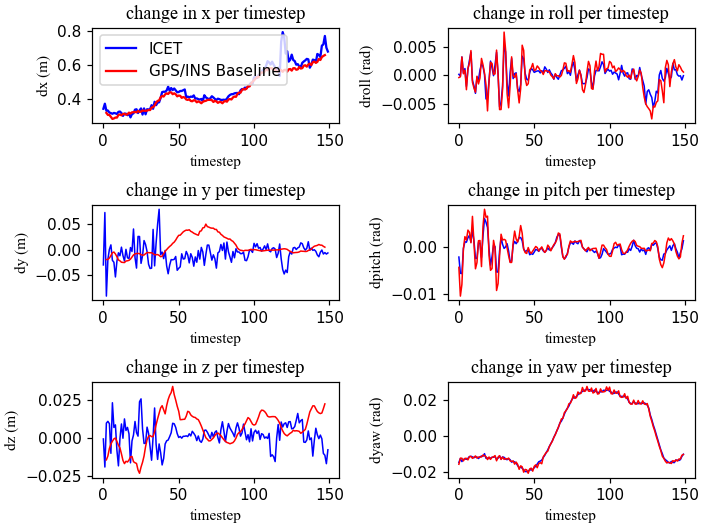

In [3]:
import matplotlib.pyplot as plt
font = {'fontname':'Times New Roman'}

# ICET_estimates = np.loadtxt("ICET_estimates_926_005.txt")
# OXTS_baseline = np.loadtxt("OXTS_baseline_926_005.txt")

ICET_estimates = np.loadtxt("ICET_estimates_926_test2.txt")
OXTS_baseline = np.loadtxt("OXTS_baseline_926_test2.txt")

# ICET_estimates = np.loadtxt("ICET_estimates_926_0018.txt")
# # ICET_estimates[:,1] = -ICET_estimates[:,1]
# OXTS_baseline = np.loadtxt("OXTS_baseline_926_0018.txt")
# # OXTS_baseline[:,1] = -OXTS_baseline[:,1]

n = 5
def moving_avg(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)

#fix sign errors...
ICET_estimates[:,1] = -ICET_estimates[:,1]
ICET_estimates[:,3:] = -ICET_estimates[:,3:]
style1 = 'b-'
style2 = 'r-'

fig, ax = plt.subplots(3,2, constrained_layout = True)
ax[0,0].plot(ICET_estimates[:,0], style1, label = 'ICET')
# ax[0,0].plot(OXTS_baseline[:,0], style2, label = 'GPS/INS Baseline')
ax[0,0].plot(np.arange(n//2, np.shape(ICET_estimates)[0] - n//2 ), moving_avg(OXTS_baseline[:,0], n),  style2, label = 'GPS/INS Baseline')
ax[0,0].set_title("change in x per timestep", **font)
ax[0,0].set_ylabel("dx (m)", **font)
ax[0,0].legend(loc = 'upper left')
ax[0,0].set_xlabel("timestep", **font)

ax[1,0].plot(ICET_estimates[:,1], style1, lw = 1)
# ax[1,0].plot(OXTS_baseline[:,1], style2, lw = 1)
ax[1,0].plot(np.arange(n//2, np.shape(ICET_estimates)[0] - n//2 ), moving_avg(OXTS_baseline[:,1], n),  style2, lw = 1)
ax[1,0].set_title("change in y per timestep", **font)
ax[1,0].set_ylabel("dy (m)", **font)
ax[1,0].set_xlabel("timestep", **font)


ax[2,0].plot(ICET_estimates[:,2], style1, lw = 1)
# ax[2,0].plot(OXTS_baseline[:,2], style2, lw = 1)
ax[2,0].plot(np.arange(n//2, np.shape(ICET_estimates)[0] - n//2 ), moving_avg(OXTS_baseline[:,2], n),  style2, lw = 1)
ax[2,0].set_title("change in z per timestep", **font)
ax[2,0].set_ylabel("dz (m)", **font)
ax[2,0].set_xlabel("timestep", **font)

ax[0,1].plot(ICET_estimates[:,3], style1, lw = 1)
ax[0,1].plot(OXTS_baseline[:,3], style2, lw = 1)
ax[0,1].set_title("change in roll per timestep", **font)
ax[0,1].set_ylabel("droll (rad)", **font)
ax[0,1].set_xlabel("timestep", **font)


ax[1,1].plot(ICET_estimates[:,4], style1, lw = 1)
ax[1,1].plot(OXTS_baseline[:,4], style2, lw = 1)
ax[1,1].set_title("change in pitch per timestep", **font)
ax[1,1].set_ylabel("dpitch (rad)", **font)
ax[1,1].set_xlabel("timestep", **font)


ax[2,1].plot(ICET_estimates[:,5], style1, lw = 1)
ax[2,1].plot(OXTS_baseline[:,5], style2, lw = 1)
ax[2,1].set_title("change in yaw per timestep", **font)
ax[2,1].set_ylabel("dyaw (rad)", **font)
ax[2,1].set_xlabel("timestep", **font)

# fig.tight_layout(h_pad = 0.1)
plt.show()

# fname = "assets/005.png"
# plt.savefig(fname)

<IPython.core.display.Javascript object>


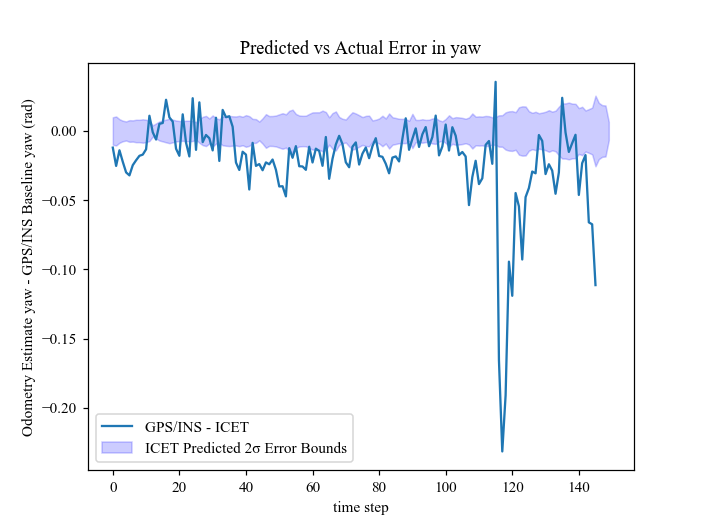

Text(0, 0.5, 'Odometry Estimate yaw - GPS/INS Baseline yaw (rad)')

In [16]:
#plot error between ICET and absolute position
plt.rc('font',family='Times New Roman')
fig3, ax3 = plt.subplots(1,1)

#load data on estimated standard deviations of each component
ICET_pred_stds = np.loadtxt("ICET_pred_stds_926_test2.txt")

#which component to look at
# c = 5 #yaw
c = 0 # x (forward movement)
window = 5

#raw - not that useful since GPS/INS is only an ESTIMATE, errors are +/- 2cm
# diffx = OXTS_baseline[:,c] - ICET_estimates[:,c]

#most honest comparison- smoothed OXTS, raw ICET
diffx = moving_avg(OXTS_baseline[:,c], window) - ICET_estimates[(window//2):-window//2+1,c]

#much cleaner - smoothing both
# diffx = moving_avg(OXTS_baseline[:,c], window) - moving_avg(ICET_estimates[:,c], window)
# diffx = moving_avg(OXTS_baseline[:,c] - ICET_estimates[:,c], window)

#adjust so means are the same?? --don't do this...
# shift = np.mean(OXTS_baseline, axis = 0) - np.mean(ICET_estimates, axis = 0)
# print(shift)
# diffx -= shift[c] 

ax3.plot(diffx, label = 'GPS/INS - ICET')
# ax3.plot(3*ICET_pred_stds[:,c], 'r-', label = 'Predicted 3σ Error Bounds')
# ax3.plot(-3*ICET_pred_stds[:,c], 'r-')
ax3.fill_between(np.linspace(0,(150-window//2+1),150), -2*ICET_pred_stds[:,c], 2*ICET_pred_stds[:,c], 
                 color = (0,0,1,0.2), label = 'ICET Predicted 2σ Error Bounds')
ax3.legend(loc = 'lower left')
ax3.set_title("Predicted vs Actual Error in yaw")
ax3.set_xlabel("time step", **font)
ax3.set_ylabel("Odometry Estimate yaw - GPS/INS Baseline yaw (rad)", **font)
# ax3.set_ylim([-0.07,0.07])

In [759]:
#TODO- get r^2 value of relationship between Q[i,0] and actual error of estimates

<IPython.core.display.Javascript object>


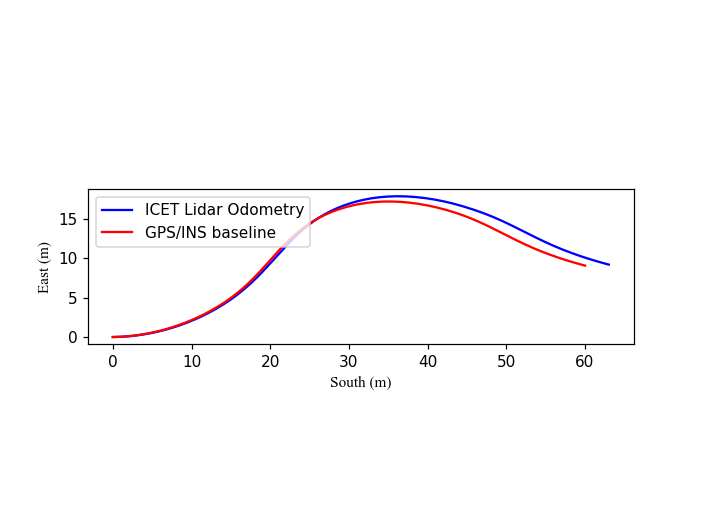

In [626]:
#plot xy total positions
fig2, ax2 = plt.subplots(1,1)
ax2.set_aspect('equal')

# ICET_estimates = np.loadtxt("ICET_estimates_926_0018.txt")
# OXTS_baseline = np.loadtxt("OXTS_baseline_926_0018.txt")

OXTS_total = np.zeros(np.shape(OXTS_baseline))
ICET_total = np.zeros(np.shape(ICET_estimates))

for i in range(np.shape(OXTS_baseline)[0]):
    OXTS_total[i] = np.sum(OXTS_baseline[:i], axis = 0)
    ICET_total[i] = np.sum(ICET_estimates[:i], axis = 0)
# ax2.plot(ICET_total[:,5])
# ax2.plot(OXTS_total[:,5])

#need to combine TOTAL heading with incremental changes in x and y (really should be ignoring y...)
ICET_traj = np.zeros([np.shape(ICET_estimates)[0], 2])
OXTS_traj = np.zeros([np.shape(ICET_estimates)[0], 2])
for j in range(1, np.shape(ICET_estimates)[0]):
    #x[i] = x[i-1] + step_dist*cos(heading)
    ICET_traj[j,0] = ICET_traj[j-1,0] + ICET_estimates[j,0]*np.cos(ICET_total[j,5]) #+ ICET_estimates[j,1]*np.sin(ICET_total[j,5])
    OXTS_traj[j,0] = OXTS_traj[j-1,0] + OXTS_baseline[j,0]*np.cos(OXTS_total[j,5]) #+ OXTS_baseline[j,1]*np.sin(OXTS_total[j,5])
    #y[i] = y[i-1] + step_dist*sin(heading)
    ICET_traj[j,1] = ICET_traj[j-1,1] + ICET_estimates[j,0]*np.sin(ICET_total[j,5]) #+ ICET_estimates[j,1] * np.cos(ICET_total[j,5])
    OXTS_traj[j,1] = OXTS_traj[j-1,1] + OXTS_baseline[j,0]*np.sin(OXTS_total[j,5]) #+ OXTS_baseline[j,1] * np.cos(OXTS_total[j,5])

    
ax2.plot(ICET_traj[:,0], -ICET_traj[:,1], 'b-', label = "ICET Lidar Odometry")
ax2.plot(OXTS_traj[:,0], -OXTS_traj[:,1], 'r-', label = 'GPS/INS baseline')
ax2.set_xlabel('South (m)', **font)
ax2.set_ylabel('East (m)', **font)
ax2.legend(loc = 'upper left')

# plt.show()

In [449]:
#get ground truth poses from text file??
path = r"C:\kitti\2011_09_26\2011_09_26_drive_0005_sync\poses\05.txt"
gt = np.loadtxt(path)
print(gt[0, :6])
print(gt[2, :6])
print(np.shape(gt))
# print(gt[-1, :6])

[1.000000e+00 1.197625e-11 1.704638e-10 1.110223e-16 1.197625e-11
 1.000000e+00]
[ 0.9999931  -0.00247504 -0.00275584  0.00117395  0.00246866  0.9999942 ]
(2761, 12)


## Parse XML file containing ground truth KITTI data

In [129]:
from bs4 import BeautifulSoup

# Reading the data inside the xml
# file to a variable under the name
# data
file = r'C:\kitti\2011_09_26\2011_09_26_drive_0005_sync\tracklet_labels.xml'
with open(file, 'r') as f:
    data = f.read()

# the beautifulsoup parser, storing
# the returned object
Bs_data = BeautifulSoup(data, "xml")
 
# Finding all instances of tag
# `tx`
x = Bs_data.find_all('tx')
# print(x[150])
print(x)

# Using find() to extract attributes
# of the first instance of the tag
b_name = Bs_data.find('child', {'name':'Frank'})
 
print(b_name)
 
# Extracting the data stored in a
# specific attribute of the
# `child` tag
value = b_name.get('test')
 
print(value)

<tx>43.325145474852846</tx>
[<tx>13.701017509034987</tx>, <tx>13.870616065076742</tx>, <tx>14.040214621118496</tx>, <tx>14.209813161996959</tx>, <tx>14.386360399526385</tx>, <tx>14.56290763705581</tx>, <tx>14.727428655391305</tx>, <tx>14.891949673726799</tx>, <tx>15.056470704320065</tx>, <tx>15.220991710397788</tx>, <tx>15.385512716475512</tx>, <tx>15.528005285117784</tx>, <tx>15.670497853760057</tx>, <tx>15.812990433018854</tx>, <tx>15.955482991044603</tx>, <tx>16.097975549070352</tx>, <tx>16.223671179874366</tx>, <tx>16.349366810678383</tx>, <tx>16.489413562050906</tx>, <tx>16.629460313423433</tx>, <tx>16.7695070522748</tx>, <tx>16.913389217112876</tx>, <tx>17.057271375518916</tx>, <tx>17.201153533924955</tx>, <tx>17.345035680181603</tx>, <tx>17.48891782643825</tx>, <tx>17.64928273771223</tx>, <tx>17.809647648986214</tx>, <tx>17.970012545922454</tx>, <tx>18.145481590213691</tx>, <tx>18.320950634504928</tx>, <tx>18.494861481576972</tx>, <tx>18.657700137122994</tx>, <tx>18.825945580600

AttributeError: 'NoneType' object has no attribute 'get'

In [107]:
print(tf.reduce_mean(errors, axis = 0))

#save to external file
fn = "2d_errors.txt"
np.savetxt(fn, errors.numpy())

tf.Tensor(
[-4.8425552e-03  4.0000887e+00 -6.3971282e-05  4.7105323e-06
  1.3820454e-06  2.2169947e-06], shape=(6,), dtype=float32)


In [108]:
a = tf.linspace(1.,10.,10)
print(a)
mask = tf.cast(tf.math.less(a, 4), tf.float32)
print(mask)
a = a*mask
print(a)
print(tf.math.reduce_max(tf.constant([1.,2.,9.])))
print(tf.math.abs([-1.,2.,3.,-0.5]))

tf.Tensor([ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.], shape=(10,), dtype=float32)
tf.Tensor([1. 1. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
tf.Tensor([1. 2. 3. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
tf.Tensor([1.  2.  3.  0.5], shape=(4,), dtype=float32)


In [ ]:
#GOAL: Keep distribution axis for neighboring ellipses on the same surface pointing in the same direction
#      if I don't do this, it will mess up my z-error??

# if largest absolute value element in 3rd column of U[i] is less than 0, multiply U[i] by -1
U = tf.constant([[[1., 2.,  4.],
                  [0., 3., -1.],
                  [1., 3., -6.]],
                  
                 [[3., 2.,  1.],
                  [0., 2.,  -9.],
                  [9., 1.,  6.]],
                
                 [[1., 1.,  -1.],
                  [1., 1.,  3.],
                  [1., 1.,  5.]]])

print(U, "\n")
# #slow loopy way
# print("slower way ----------------------------")
# for i in range(tf.shape(U)[0]):
#     a = tf.math.reduce_max(tf.abs(U[i,:,2]))
#     print(a)
#     b = tf.where(tf.equal(tf.abs(U[i,:,2] ), a ))[0,0]
#     print(b) 
#     print(U[i,b,2])
#     if U[i,b,2] < 0:
#         print("gotta reverse U \n")

#faster vectorized way
print("\n faster way ---------------------")
a = tf.math.reduce_max(tf.abs(U[:,:,2]), axis = 1)[:,None]
# print(a)
b = tf.where( tf.math.equal(tf.abs(U[:,:,2]), a) )
# print(b)
# print("U[:,:,2] \n", U[:,:,2])
absmax = tf.gather_nd(U[:,:,2], b)
print("absmax: \n", absmax)

#test: only look at one comonent of direction of largest ditribution axis
# absmax = U[:,0,2]
# print(absmax)

mask = (-2.*tf.cast(tf.math.less(absmax, 0), tf.float32) + tf.ones(tf.shape(absmax)))[:,None][:,None]
print("mask: \n", mask)

# print("output: ", mask*U)


In [ ]:
L = tf.tile(tf.eye(3)[None,:,:], (2, 1, 1))
print(L)

In [ ]:
#test out multiplying voxel means by either ragged tensor or by zero padded (3x3) tensor
# make sure results are the same
#BAD WAY...

L1 = tf.constant([[[1., 0., 0.],
                 [0., 1., 0.],
                 [0., 0., 1.]],

                [[0., 0., 0.],
                 [0., 0., 0.],
                 [0., 0., 0.]],
                
                [[1., 0., 0.],
                 [0., 1., 0.],
                 [0., 0., 0.]]])

values = tf.tile(tf.eye(3), (3,1))
useful = tf.constant([0,1,2,6,7]) #useful directions for ICET
uv = tf.gather(values, useful)
print("uv: \n", uv)

# starts = [0, 3, 4]
# L2 = tf.RaggedTensor.from_row_starts(values, starts)

#find where first element of each row is equal to 1
# w = tf.transpose(tf.where(uv[:,0] == 1))
# print("w \n", w)

#find where every first row is NOT 1 so we can add those to row_limits to create placeholder zero tensors
everyThird = tf.range(0,tf.shape(values)[0],3, dtype = tf.int64)[None,:]
print("\n every third \n", everyThird)
#find elements of everyThird that are not in <useful>
both = tf.sets.intersection(everyThird, tf.cast(useful, tf.int64)[None,:])
both = tf.sparse.to_dense(both)
print("\n both \n ", both)
placeholers = tf.where(everyThird == both)

row_limits = [3,3,5] #temp -> write code to gen this automatically

L2 = tf.RaggedTensor.from_row_limits(uv, row_limits)
print("\n L2 \n", L2.to_tensor())

test1 = L1 @ U
# print("\n test1 \n", test1)

# test2 = L2.to_tensor() @ U
# print("\n test2 \n", test2)
# print(L2)



In [ ]:
#Better way...
I = tf.tile(tf.eye(3), (4,1))
print("eye \n", I)
short = tf.constant([0,1,2,6,7,9]) #useful directions for ICET
print("\n useful \n", useful)

data = tf.ones((tf.shape(short)[0],3))
print("\n data \n", data)

mask = tf.scatter_nd(indices = short[:,None], updates = data, shape = tf.shape(I))
print("\n mask \n", mask)

ans = mask * I
ans = tf.reshape(ans, (tf.shape(ans)[0]//3,3,3))
print("\n ans \n",ans)

In [ ]:
tf.range(0,tf.shape(values)[0],3)

### Proof that extended axis truncation == etended axis zeroing

In [ ]:
L1 = tf.constant([[1., 0., 0.],
                  [0., 1., 0.],
                  [0., 0., 0.]])
print("\n L1 \n", L1)

L2 = tf.constant([[1., 0., 0.],
                  [0., 1., 0.]])
print("\n L2 \n", L2)

U = R(tf.constant([1.,2.,3.]))

sigma = tf.random.uniform((3,3))

#fake calculation of R_noise
test1 = L1 @ tf.transpose(U) @ sigma @ U @ tf.transpose(L1)
print("\n test1 \n", test1)

test2 = L2 @ tf.transpose(U) @ sigma @ U @ tf.transpose(L2)
print("\n test1 \n", test2)


In [ ]:
#truncating L matrix does the same thing as zeroing out end rows...
L3 = tf.constant([[1.,0.,0.],
                  [0., 1., 0.]])
print(L3 @ U[0])
print(L1[2] @ U[0])

In [ ]:
#test - multiply a [6,6] tensor with a [N, 6, 3] tensor
# A = tf.eye(6)        #[6, 6]
# B = tf.ones([2,6,3]) #[2, 6, 3]
# print(tf.shape(tf.matmul(A,B))) #[2, 6, 3]

C = tf.ones([164, 6,3])
D = tf.ones([164,3])[:,:,None]
print(tf.shape(tf.matmul(C,D)))

In [ ]:
a = tf.ones([2,3,3])
b = tf.ones([2,3,3])
# print(a, b)
print(a * b)
print(a @ b)
print(tf.matmul(a,b))

In [ ]:
t = tf.random.uniform([10,3])
print(t)
lims = [tf.constant([1]), tf.constant([2])]
rag = tf.RaggedTensor.from_row_splits(t, lims)
print(rag)

## Subdivide scan using NumPy

In [ ]:
## from vedo import *
from utils import *
import numpy as np
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti

settings.embedWindow(backend='ipyvtk', verbose = True) #was this

try:
    plt1.closeWindow()
    print("closed")
except:
    pass

plt1 = Plotter(N=1, axes=1, bg = (0.1,0.1,0.1), bg2 = (0.3,0.3,0.3),  interactive=True)
# settings.useParallelProjection = True #makes view orthographic

## uncomment to use VOLPE dataset -----------------------------------------------------
# location = 'C:/Users/Derm/2021-03-10-16-43-50_Velodyne-VLP-16-Data_garminSignage.txt'
# cloud = np.loadtxt(open(location, "rb"), delimiter=",")
# cloud = cloud[~np.isnan(cloud).any(axis=1)] #remove all rows with NaN elements
## ------------------------------------------------------------------------------------

## uncomment to use KITTI dataset -----------------------------------------------------
basedir = 'C:/kitti/'
date = '2011_09_26'
drive = '0005'
frame_range = range(150, 151, 1)
dataset = pykitti.raw(basedir, date, drive)
velo1 = dataset.get_velo(0) # Each scan is a Nx4 array of [x,y,z,reflectance]
cloud = velo1[:,:3]
## ------------------------------------------------------------------------------------

# make 2D sinusioal pattern (for debug) ------------------------------------------------
# cloud = np.random.randn(10000,3)
# cloud[:,0] += -50*cloud[:,1] + np.random.randn()*5
# cloud[:,1] += 5
# cloud[:,1] = cloud[:,1] * 3 + 10*np.random.randn() + np.sin(cloud[:,1]*5)*10
# cloud[:,2] += 0.5*cloud[:,1] - 10
##-------------------------------------------------------------------------------------

# f =np.array([200,200,40]) #fidelity in x, y, z #takes ~30s on my dsektop
# lim = np.array([-50,50,-50,50,-10,10])

f =np.array([100,100,2]) #fidelity in x, y, z # < 5s
lim = np.array([-100,100,-100,100,-10,10])

for _ in range(1):
#     cloud_partial = tf.gather(cloud,tf.cast((tf.linspace(1,100000,100)), tf.int32))
    cloud_partial = cloud
    mus, sigmas, sizes = subdivide_scan(cloud_partial,plt1, bounds = lim, fid = f, draw_grid = False, show_pc = True) 

# print("\n mus: \n", mus)
# print("\n sigmas: \n", sigmas, np.shape(sigmas))
    
ViewInteractiveWidget(plt1.window)

## Subdivide scan using TensorFlow

In [ ]:
## from vedo import *
from utils import *
import numpy as np
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti

settings.embedWindow(backend='ipyvtk', verbose = True) #was this

plt2 = Plotter(N=1, axes=1, bg = (0.1,0.1,0.1), bg2 = (0.3,0.3,0.3),  interactive=True)

## uncomment to use KITTI dataset -----------------------------------------------------
basedir = 'C:/kitti/'
date = '2011_09_26'
drive = '0005'
frame_range = range(150, 151, 1)
dataset = pykitti.raw(basedir, date, drive)
velo1 = dataset.get_velo(0) # Each scan is a Nx4 array of [x,y,z,reflectance]
cloud = velo1[:,:3]
cloud_tensor = tf.convert_to_tensor(cloud, np.float32)
# print(tf.shape(cloud))
## ------------------------------------------------------------------------------------

# # make 2D sinusioal motion (for debug) ------------------------------------------------
# cloud = np.random.randn(10000,3)
# cloud[:,0] += -50*cloud[:,1] + np.random.randn()*5
# cloud[:,1] += 5
# cloud[:,1] = cloud[:,1] * 3 + 10*np.random.randn() + np.sin(cloud[:,1]*5)*10
# cloud[:,2] += 0.5*cloud[:,1] - 10
# #-------------------------------------------------------------------------------------

f = tf.constant([100,100,2]) #fidelity in x, y, z # < 5s
lim = tf.constant([-100.,100.,-100.,100.,-10.,10.])
DRAW = True

for _ in range(1):
#     cloud_partial = tf.gather(cloud,tf.cast((tf.linspace(1,100000,30)), tf.int32))
    cloud_partial = cloud
    E = subdivide_scan_tf(cloud_partial, plt2, bounds = lim, fid = f, draw=DRAW, draw_grid = False, show_pc = 1) 
# print("\n points: \n", cloud_partial)

# mu = E[0]
# print("\n mu: \n",mu)

# sigma = E[1]
# print("\n sigma: \n", sigma)

# print(tf.transpose(sigma))
# print("\n sigma[:,:,1] \n", sigma[:,:,0])

# sig2 = tf.reshape(tf.transpose(sigma), (tf.shape(sigma)[1] ,3,3))
# print("reshaped sigma \n", sig2)

# shapes = E[2]
# print("\n shapes: \n", shapes)

# sigma = E[1]
# print(tf.shape(sigma),sigma[:,:,1])

# if DRAW:
ViewInteractiveWidget(plt2.window)


### kNN

In [ ]:
# a = tf.constant([1.,1.,1.]) #works ------------------------------
# print("\n a \n", a)

# b = tf.random.normal([10,3])
# print("\n b \n", b)

# dist = tf.reduce_sum(tf.math.squared_difference(a,b), axis = 1)
# ans = tf.where(dist == tf.math.reduce_min(dist))[0,0]
# print("\n ans \n", b[ans])
## -----------------------------------------------------------------

# batch input - not working yet ------------------------------------
a = tf.constant([[[1., 1., 1.]],
                 [[0., 0., 0.]],
                 [[0., 0., 0.]]])  
print("\n a \n", a)

b = tf.random.normal([10,3])
print("\n b \n", b)

# print(tf.gather(a,(0,1)))
# print(tf.math.subtract(a, b))
# print(tf.square(a-b))
dist = tf.math.reduce_sum( (tf.square( tf.math.subtract(a, b) ))  , axis = 2)
print("\n dist \n", dist)

ans = tf.where( tf.transpose(dist) ==tf.math.reduce_min(dist, axis = 1))
print("\n shortest dist \n", ans)

reordered = tf.argsort(ans[:,1], axis = 0)
print("\n reordered \n", tf.gather(ans,reordered))


### Create ragged tensor given row sizes

In [ ]:
sizes = tf.constant([1,2,8,4,5])

# dummy_vals would be (points_x - mu_x)
v = tf.random.uniform([tf.math.reduce_sum(sizes)])
dummy_vals = tf.RaggedTensor.from_row_lengths(v ,sizes) 
print(dummy_vals.to_tensor() - 1)
mask_test = tf.RaggedTensor.from_row_lengths(tf.ones(tf.math.reduce_sum(sizes)) ,sizes)
print(tf.transpose(mask_test.to_tensor()))
print((dummy_vals.to_tensor() -1) * mask_test.to_tensor())

## Unit Test R() and Jacobian

In [ ]:
n_hat = np.array([1,0,0])
theta =  0.1 #np.pi/6 #rad

rot_mat_simp = R_simp(n_hat, theta)
print(rot_mat_simp)
angs = np.array([theta,0 ,0])
rot_mat = R(angs)
print(rot_mat)

print(R2Euler(rot_mat))

p_point = np.array([1,1,1]).T

J = jacobian(angs, p_point)

d_rot_mat_simp = dR_simp(n_hat,theta)
# print(d_rot_mat_simp)

## Unit test R2Euler_tf and R_tf
#### Works with single axis roation
#### Works with vectoried input
#### Solution becomes ambiguious with mutliple axis inputs

In [ ]:
angs = tf.random.normal((3,1)) * tf.constant([[0.], [0.], [1.] ]) #single axis angle input
# angs = tf.Variable([[0.],[ np.pi/2],[ 0.]]) #vector input, multiple axis rotation
print("Input angs: \n", angs.numpy())
# print("R(angs): \n", R_tf(angs).numpy())
test1 = R2Euler_tf(R_tf(angs))
print("R2Euler_tf(R(angs)): \n", test1.numpy())
# test2 = R2Euler(R(angs[:,:2]))
# print(test2)

### Unit test tfp find bins

In [ ]:
c = tf.convert_to_tensor(cloud, np.float32)#[:100]
# print("c: \n", c.numpy())
startx = -100.
stopx = 100.
numx = 10
edgesx = tf.linspace(startx, stopx, numx)
xbins = tfp.stats.find_bins(c[:,0], edgesx)
print(xbins)
starty = -100.
stopy = 100.
numy = 10
edgesy = tf.linspace(starty, stopy, numy)
ybins = tfp.stats.find_bins(c[:,1], edgesy)
print(ybins)

min_num_pts = 1000

count = 0
E = []

for x in range(numx):
    for y in range(numy):
        #only do calculations if there are a sufficicently high number of points in the bin
        xin = tf.where(xbins == x)
        if tf.shape(xin)[0] > min_num_pts:
            if tf.shape(tf.where(tf.gather(ybins, xin) == y))[0] > min_num_pts: #repeat for y points at x coord
#                 print("working", x, y)
                count += 1
# print(xin)
# print(ybins)
print(count)

In [ ]:
test = tf.linspace(1,5,5)
print(test)
ans = tf.where(test < 4)
print("ans: \n",ans)
print("\n", tf.gather(test, ans))


## Inline volumetric rendering using ipyvolume

In [ ]:
#simple demo
import ipyvolume
ds = ipyvolume.datasets.aquariusA2.fetch()
short = ds.data[:,:,:]
ipyvolume.quickvolshow(short, lighting=True)

In [ ]:
ans = np.linspace(1,12,8)
ans[2] = 0
print(ans)

test = ans[ans < 10]
print(test)
np.shape(test)[0]

print(np.median(test[:3]))

In [ ]:
tes = tf.random.normal([3,3])
print(tes)
print(tf.reverse(tes, axis = [1]))

In [ ]:
# a = tf.reshape([10.,10.,2.], (3,1))
# print(type(a))
# t = tf.Tensor(a, dtype = "float32")

a = tf.constant([2.1,2.,3.])
b = tf.constant([1.,2.,3.])
tf.tensordot(a,b, axes = 0)

In [ ]:
eye = tf.eye(3)
# print(j)
Jx = tf.constant([[1.], [2.], [3.]])
J = tf.concat([eye, Jx], axis = 1)
print(J)

### compare jacobian() and jacobian_tf()

In [ ]:
# print(tf.sin(1.))
start = time.time()
numiter = 1000
angs  = np.array([1.,0.1,0.1])
p_point = np.array([1.,2.,3.])
for _ in range(numiter):
    J = jacobian(angs, p_point);
print("took", time.time()-start, "seconds on CPU")
print(J)

In [ ]:
#TF is slower if we do them one by one BUT is waaay faster if we send them in all at once
start = time.time()
numiter = 1000
# angs = tf.random.normal((3,numiter))
angs = tf.constant([1.,2.,3.])
p_point = tf.random.normal((3,numiter))
J = jacobian_tf(p_point, angs);
print("took", time.time()-start, "seconds on GPU")
print(J)

### Testing subdividing cells without loop

In [ ]:
#Goal: given input tensor "cloud" and "bins" which contains all og and binned coordinates
#      subdivide and perform ops on "cloud" wihtout using any loops 

bins = tf.transpose(tf.constant([[2., 1., 3., 0., 2., 2., 3., 1., 0., 2.],
                                 [0., 1., 0., 0., 0., 0., 3., 1., 0., 0.],
                                 [1., 2., 3., 0., 1., 1., 3., 2., 0., 1.]]))
cloud = bins + tf.random.normal(tf.shape(bins))*0.1
print("binned coordinate values: \n", bins)
# print(cloud)

#1d case (easy)
# q = tf.constant([1., 1., 2.]) 
# print(tf.squeeze(tf.gather(bins, ans))) #works for 1d, unsure of utility in 2d
#2d case (hard)
q = tf.constant([[[1., 1., 2.]],
                 [[0., 9., 9.]],
                 [[2., 0., 1.]],
                 [[7., 8., 9.]]])
print("\n cells of interest: \n",q)

idx = tf.equal(bins, q)
print(idx)
#ans outputs tensor of shape [N,2], where:
#  [[voxel number, index of [x,y,z] in cloud that corresponds to bin #],
#   [voxel number,index of [x,y,z] in cloud that corresponds to bin #]] ... 
loc = tf.where(tf.math.reduce_all(idx, axis = 2) == True)
print("\n loc: \n", loc)

#Need to "ungroup" so that we can fit_gaussian_tf() to each individual voxel...
s = tf.shape(loc)
group_ids, group_idx = tf.unique(loc[:, 0], out_idx=s.dtype)
num_groups = tf.reduce_max(group_idx) + 1
# print(group_ids, group_idx, num_groups)
sizes = tf.math.bincount(group_idx)
# print(sizes)

#replace <bins> here with <cloud> when done debugging
rag = tf.RaggedTensor.from_row_lengths(tf.gather(cloud, loc[:,1]), sizes) 
# print("ragged: \n", rag)

#Run on GPU as vectorized operation (WAAAAAY Faster) --
reg = tf.RaggedTensor.to_tensor(rag)
print("\n regular tensor: \n", reg)
mu, sigma = fit_gaussian_tf(reg)
print("mu: \n", mu)
print("sigma: \n", sigma)
#------------------------------------------------------- 

# # works but uses loop (runs on CPU -> slow) -----------
# A =  tf.data.Dataset.from_tensor_slices(rag)
# mus = []
# sigmas = []
# for i in range(len(A)):
#     mu, sigma = fit_gaussian_tf(rag[i])
#     mus.append(mu)
#     sigmas.append(sigma)
# print(mus, sigmas)
# #------------------------------------------------------

### Find "loc" more efficiently than using tf.where

In [ ]:
print("binned points: \n", bins)
print("\nbins to place them: \n",q)

# #SUPER inefficient 
# for i in range(tf.shape(bins)[0]):
#     for j in range(tf.shape(q)[0]):
#         if tf.reduce_all(bins[i] == q[j]):
#             print(j,i)
#             try:
#                 loc2 = tf.concat((loc2, tf.constant([[j,i]])), axis = 0)
#             except:
#                 loc2 = tf.constant([[j,i]])
# print("\n loc \n",loc2)
# loc2 = None

testidx = tf.where(bins == q[1])
print(testidx)
    
print("\n goal is to get this: \n",loc)

### remove zero rows from 3d tensor

In [ ]:
bins2 = tf.transpose(tf.constant([[[2., 9., 3., 0., 2., 2., 3., 1., 0., 2.], #x
                                  [0., 0., 0., 0., 0., 0., 3., 1., 0., 0.],
                                  [0., 1., 0., 0., 0., 0., 3., 1., 0., 0.],
                                  [1., 2., 3., 0., 1., 1., 3., 2., 0., 1.]], 
                                  
                                  [[2., 1., 3., 0., 2., 2., 3., 1., 0., 2.], #y
                                  [0., 0., 0., 0., 0., 0., 3., 1., 0., 0.],
                                  [0., 1., 0., 0., 0., 0., 3., 1., 0., 0.],
                                  [1., 2., 3., 0., 1., 1., 3., 2., 0., 1.]],
                                  
                                  [[2., 1., 3., 1., 2., 2., 3., 1., 0., 2.], #z
                                  [0., 0., 0., 0., 0., 0., 3., 1., 0., 0.],
                                  [0., 1., 0., 0., 0., 0., 3., 1., 0., 0.],
                                  [1., 2., 3., 0., 1., 1., 3., 2., 0., 1.]]]))

print(bins2[:2])
print(bins2[:,:,0])
#need to AVERAGE point locations PER AXIS, PER BIN
#   Ignore SPECIFIC POINTS where XYZ are ALL ZERO
idx = tf.math.not_equal(bins2[:,:,0], tf.constant([0.,0.,0.]))
print(idx[:2])
mask = tf.where(tf.math.reduce_any(idx, axis = 2) == True)
print("\n mask: \n", mask[:6]) #correct(?)
# print(tf.gather(bins,mask))

nonzero = tf.gather(bins,[0,0,0])
print("\n nonzero elements: \n", nonzero)

### Generate 2D tensor with all permutations (:n1, :n2, :n3)

In [ ]:
fida = 2 
fidb = 4
fidc = 1

a = tf.linspace(0,fida-1,fida)[:,None]
b = tf.linspace(0,fidb-1,fidb)[:,None]
c = tf.linspace(0,fidc-1,fidc)[:,None]

ansa = tf.tile(a, [fidb*fidc, 1])
ansb = tf.tile(tf.reshape(tf.tile(b, [1,fida]), [-1,1] ), [(fidc), 1])
ansc = tf.reshape(tf.tile(c, [1,fida*fidb]), [-1,1] )

q = tf.squeeze(tf.transpose(tf.Variable([ansa,ansb,ansc])))
print(q)

#GOAL- determine which voxel pt belongs in based on its coords
# pt = tf.constant([2,1,0])
pt = bins
print("\n pt:", pt, "\n")
num = tf.cast( ( pt[:,0] + fida*pt[:,1] + (fida*fidb)*pt[:,2] ), tf.int32)
print("\n", num, "\n")
# print(q[num])

ans = tf.concat((num[:,None], tf.cast(tf.linspace(0, tf.shape(pt)[0], tf.shape(pt)[0]  )[:,None],
                                      dtype = tf.int32) ), axis = 1 )
print(ans)


### Calculate covariance of 3d tensors with multiple voxels. Ignore zeros.

In [ ]:
a = tf.random.normal(shape=(10, 2, 1))
b = tf.random.normal(shape=(10, 2, 1))*4
c = tf.random.normal(shape=(10, 2, 1))

d = tf.concat((a,b,c), axis = 2)
d = tf.concat((d, tf.zeros((10,2,3))), axis = 0)
print(d[:,1])

I = tf.sparse.eye(10,3)
print("\n Sparse Identity: \n", I)

cov = tfp.stats.covariance(d, sample_axis = 0, event_axis = 2)
print("\n covariance matrices: \n", cov[1])

print(sizes)


In [ ]:
print(tf.cast((tf.linspace(1,1000,100)), tf.int32))